# Semi-synthetic environment

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
cd zr-obp/


/home/foundry/jupyter/shion.ishikawa/workspace/research/zr-obp


In [93]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

from obp.ope.estimators import InverseProbabilityWeighting
from obp.policy.linear import LinTS
from obp.policy.contextfree import BernoulliTS, Random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from obp.dataset import SyntheticBanditDataset
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, Random
# ALEXPは、linearなsubpolicyしか使えないので検証に使わないかも
from obp.policy.model_selection import ModelSelectionPolicy, MetaExp3P, MetaCORRAL, MetaEXPOPE
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)
import pandas as pd
from obp.simulator.simulator import BanditEnvironmentSimulator
from tqdm import tqdm
import seaborn as sns
sns.set()


In [321]:
# config
n_rounds = 100
num_batch = 200
T = n_rounds * num_batch
n_actions = 5
dim_context = 28
n_random_seed = 5
#lambdas = [0, 2.5, 5, 7.5, 10]

lambdas = [0, 0.25, 0.5, 2.5, 5]

In [348]:
# create regression model with entire dataset
df = pd.read_csv('../all.csv', index_col=0)

In [349]:
df.groupby('item_id').click.mean()

item_id
0     0.002718
1     0.002214
2     0.001272
3     0.002570
4     0.001148
        ...   
75    0.002109
76    0.002942
77    0.004035
78    0.004790
79    0.004552
Name: click, Length: 80, dtype: float64

In [350]:
high_ctr_bnrs = [48, 58, 39, 35, 60]

In [351]:
df = df[df.item_id.isin(high_ctr_bnrs)]

In [352]:
dummy_cols = ['user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3']
df = pd.get_dummies(df[['click', 'item_id'] + dummy_cols], columns=dummy_cols)

In [353]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df.item_id = label_encoder.fit_transform(df.item_id)


In [311]:
reward_models = {}
for i in range(5):
    X = df[df.item_id == i].iloc[:, 2:].values
    y = df[df.item_id == i].click.values
    print(X.shape)
    print(y.sum())
    reward_models[i] = LogisticRegression(random_state=0).fit(X, y)

(17335, 28)
129
(17396, 28)
123
(16576, 28)
104
(16913, 28)
113
(16325, 28)
128


In [312]:
def semisync_reward_function(context, action_context, coef_function,
                             reward_function=reward_models, random_state=42):
    result = pd.DataFrame()
    n_action = action_context.shape[1]
    for action in range(n_action):
        result[str(action)] = reward_models[action].predict_proba(context)[:, 1]
    return result.values

In [339]:
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    policy = BernoulliTS(n_actions=n_actions)
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action())
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        for a, r in zip(np.array(actions), rewards[np.arange(len(rewards)), np.array(actions)]):
            policy.update_params(action=a, reward=r)
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:01<00:00, 126.40it/s]


17201


100%|██████████| 200/200 [00:01<00:00, 126.83it/s]


16380


100%|██████████| 200/200 [00:01<00:00, 125.59it/s]


15060


100%|██████████| 200/200 [00:01<00:00, 125.50it/s]


18006


100%|██████████| 200/200 [00:01<00:00, 126.64it/s]

16070


In [340]:
pd.DataFrame(regrets).to_csv('../ts_real_regret.csv')

In [341]:
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    policy = LinTS(dim=dim_context, n_actions=n_actions)
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action(context))
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        for a, r, c in zip(np.array(actions), rewards[np.arange(len(rewards)), np.array(actions)], contexts):
            policy.update_params(action=a, reward=r, context=np.array(c[np.newaxis, :]))
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:19<00:00, 10.15it/s]


15633


100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


15827


100%|██████████| 200/200 [00:19<00:00, 10.24it/s]


15877


100%|██████████| 200/200 [00:19<00:00, 10.27it/s]


15994


100%|██████████| 200/200 [00:19<00:00, 10.24it/s]


15968


In [343]:
pd.DataFrame(regrets).to_csv('../lints_real_regret.csv')

In [ ]:
# まあ本質とは関係ないので、しれっとTSとLinTSを使っていることを言うか

In [328]:
# meta exp ope
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    lints = LinTS(dim=dim_context, n_actions=n_actions)
    ts = BernoulliTS(n_actions=n_actions)
    policy = MetaEXPOPE(dim=dim_context, policies=[lints, ts], n_actions=n_actions, T=T)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action(context))
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


15171


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


15555


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


16267


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


16647


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]

15849


In [329]:
pd.DataFrame(regrets).to_csv('../metaexp3ope_real_regret.csv')

In [ ]:
# 結局non-personalized/personalzied両方のケースでうまくいくことを言いたい

In [354]:
# meta exp3p
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    lints = LinTS(dim=dim_context, n_actions=n_actions)
    ts = BernoulliTS(n_actions=n_actions)
    policy = MetaExp3P(dim=dim_context, policies=[lints, ts], n_actions=n_actions)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action(context))
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:12<00:00, 16.56it/s]


15958


100%|██████████| 200/200 [00:11<00:00, 16.78it/s]


15948


100%|██████████| 200/200 [00:12<00:00, 16.56it/s]


15295


100%|██████████| 200/200 [00:12<00:00, 16.53it/s]


15961


100%|██████████| 200/200 [00:11<00:00, 16.81it/s]

16542


In [355]:
pd.DataFrame(regrets).to_csv('../metaexp3p_real_regret.csv')

In [333]:
# meta exp3p
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    lints = LinTS(dim=dim_context, n_actions=n_actions)
    ts = BernoulliTS(n_actions=n_actions)
    policy = MetaCORRAL(dim=dim_context, policies=[lints, ts], n_actions=n_actions, T=T)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action(context))
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:10<00:00, 19.20it/s]


16077


100%|██████████| 200/200 [00:10<00:00, 19.35it/s]


17412


100%|██████████| 200/200 [00:14<00:00, 13.55it/s]


15952


100%|██████████| 200/200 [00:07<00:00, 25.13it/s]


16173


100%|██████████| 200/200 [00:13<00:00, 15.14it/s]

15886


In [334]:
pd.DataFrame(regrets).to_csv('../metacorral_real_regret.csv')

In [337]:
# meta exp3p
np.random.seed(0)
regrets = []
lam = 1
for seed in range(n_random_seed):
    be = BanditEnvironmentSimulator(n_actions=5, dim_context=dim_context, reward_function=semisync_reward_function)
    lints = LinTS(dim=dim_context, n_actions=n_actions)
    ts = BernoulliTS(n_actions=n_actions)
    policy = ModelSelectionPolicy(dim=dim_context, mode='OPE', policies=[lints, ts], n_actions=n_actions, epsilon=0.1)
    regret = []
    for i in tqdm(range(num_batch)):
        # observe contexts
        contexts = df.iloc[:, 2:].sample(n=n_rounds).values
        actions = []
        for context in contexts:
            actions.append(policy.select_action(context))
        # observe rewards
        # adjust impact of contetual effect for reward function
        expected = be.calc_expected_reward(contexts * lam)
        best_actions = pd.DataFrame(expected).idxmax(axis=1)
        regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
        rewards = be.sample_reward(contexts * lam)
        actions = np.array(actions).flatten()
        policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
    result = [lam]
    print(np.array(regret).flatten().sum())
    regrets.append(regret)

100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


15725


100%|██████████| 200/200 [00:36<00:00,  5.55it/s]


15739


100%|██████████| 200/200 [00:35<00:00,  5.57it/s]


15838


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


15825


100%|██████████| 200/200 [00:35<00:00,  5.67it/s]

15936


In [338]:
pd.DataFrame(regrets).to_csv('../metagreedyope_eps0.1_real_regret.csv')

# Regret Analysis

In [363]:
models = ['metaexp3ope', 'metaexp3p', 'metagreedyope_eps0.1', 'metacorral', 'lints', 'ts']

In [395]:
al = pd.DataFrame()
for model in models:
    df = pd.read_csv(f'../{model}_real_regret.csv', index_col=0)
    lis = []
    for i in range(df.shape[0]):
        li = []
        for j in range(df.shape[1]):
            li += eval(df.iloc[i, j])
        lis.append(li)
    
    regrets = pd.DataFrame(lis).cumsum(axis=1)
    regrets['model'] = model
    al = pd.concat([al, regrets], axis=0)


In [396]:
al = pd.melt(al.iloc[:, ::1000], id_vars='model')


Text(0.5, 0, 'steps')

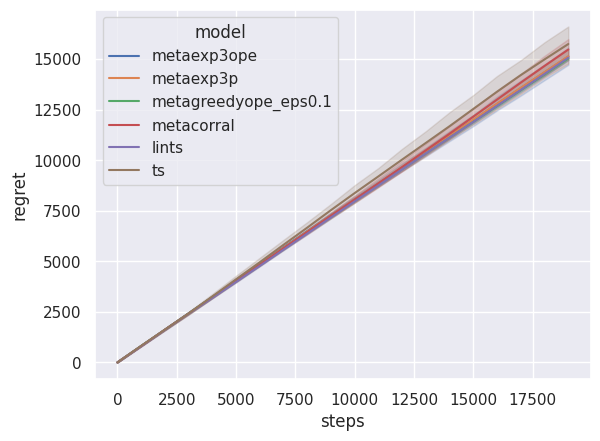

In [397]:
sns.lineplot(data=al, x='variable', y='value', hue='model', palette='deep')
plt.ylabel(f'regret')
plt.xlabel(f'steps')
#plt.title(f'{fname}')

In [399]:
al = pd.DataFrame()
for model in models:
    df = pd.read_csv(f'../{model}_real_regret.csv', index_col=0)
    lis = []
    for i in range(df.shape[0]):
        li = []
        for j in range(df.shape[1]):
            li += eval(df.iloc[i, j])
        lis.append(li)
    
    regrets = pd.DataFrame(lis).cumsum(axis=1)
    al[model] = regrets.iloc[:, -1]


In [400]:
al = pd.melt(al)


In [404]:
al.groupby('variable').value.mean()

variable
lints                   15859.8
metacorral              16300.0
metaexp3ope             15897.8
metaexp3p               15940.8
metagreedyope_eps0.1    15812.6
ts                      16543.4
Name: value, dtype: float64

In [413]:
al.groupby('variable').value.std().apply(lambda x: round(x, 1))

variable
lints                    143.6
metacorral               631.4
metaexp3ope              580.0
metaexp3p                441.4
metagreedyope_eps0.1      85.3
ts                      1120.6
Name: value, dtype: float64